# Modelamiento
----------------------------------------------

MLDS 6 - Grupo 8


### Librerias y configuraciones

In [ ]:
!pip install scikeras
!pip install pyngrok
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 25.4 MB/s eta 0:00

In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
tf.random.set_seed(42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
import os
from IPython.display import display
from pyngrok import ngrok
import mlflow
import mlflow.sklearn
import re
import requests
import pickle


In [ ]:
def list_confusion_matrix(cm,classes):
  df = pd.DataFrame(data = cm,
                    index = pd.MultiIndex.from_product([['Valor real'], classes]),
                    columns = pd.MultiIndex.from_product([['Valor predicho'], classes]))

  return df

In [ ]:
names=['No_Diabetes', 'Diabetes']

## Autenticación en MLflow
-------------------------------------------

Antes de desplegar el modelo, se configura todo el entorno de ML flow, primero se lanza un servidor web.

In [ ]:
command = """
mlflow server \
        --backend-store-uri sqlite:///tracking.db \
        --default-artifact-root file:mlruns \
        -p 5000 &
"""
get_ipython().system_raw(command)

se extrae el token que nos proporciona la plataforma de ngrok

In [ ]:
token = "2gFliDMxc3tfsLh0I0TlwThCN9D_5jpazRWnVfVzhLPrGymzZ"
os.environ["NGROK_TOKEN"] = token
!ngrok authtoken $NGROK_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


y lanzamos la conexión com ngrok

In [ ]:
ngrok.connect(5000, "http")

<NgrokTunnel: "https://adce-34-67-204-66.ngrok-free.app" -> "http://localhost:5000">

se define el servidor que MLflow estará manejando

In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")

Se crea un experimento de MLflow donde se guardaran los modelos

In [ ]:
exp_id = mlflow.create_experiment(name="diabetes_model", artifact_location="mlruns/")

## Lectura de sub conjunto de datos de train y test
-----------------------------------

Se cargan los datos resultado de la sección de preprocesamiento, y se verifica que no haya un cambio en sus dimensiones.

In [ ]:
DATA_URL = 'https://github.com/cris21309/tdsp_template_grupo8/blob/preprocesamiento/scripts/preprocessing/train_test_array.npz?raw=true'

path = tf.keras.utils.get_file('train_test_array.npz', DATA_URL)

with np.load(path) as data:
  X_train = data['X_train']
  X_test  = data['X_test']
  y_train = data['y_train']
  y_test = data['y_test']

12307690/12307690 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Análisis de modelos de Machine learning
---------------------------------------
En esta etapa se utilizaran algoritmos supervisados con validacion cruzada K-fold para encontrar el mejor modelo y los hiperparametros mas adecuados para la clasificación que se desea obtener.

### Regresion logistica
----------------------------------------
Se selecciono la técnica de regresión logística debido a su eficiencia y robustez para clasificación binaria, ademas de su eficiecnia computacional. Para la validación cruzada se tendran en cuenta, hiperparametros como: el tipo de optimizacion, solver, y las iteraciones maximas.

In [ ]:
param_grid = {
    'penalty': ['l2', None],
    'solver': ['lbfgs'],
    'max_iter': [100, 200, 400, 800],
}

Se utiliza la herramienta gridsearchcv para la que se configura para 5 particiones al realizar CV

In [ ]:
grid_lg = GridSearchCV(LogisticRegression(random_state=3,),
                   param_grid=param_grid,
                   verbose=1,
                   return_train_score=True,
                   cv = 5
                   )
grid_lg.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=3),
             param_grid={'max_iter': [100, 200, 400, 800],
                         'penalty': ['l2', None], 'solver': ['lbfgs']},
             return_train_score=True, verbose=1)

Se realiza un dataframe que contiene los mejores score de los primeros modelos entrenados, este indica los hiperparametros seleccionados en cada iteración, asi como las metricas obtenicas por cada split y su respectivo promedio y desviacion estandar al final.

In [ ]:
pd.DataFrame(grid_lg.cv_results_).sort_values(by='rank_test_score', ascending=True).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.252673,0.083269,0.007418,0.003153,100,l2,lbfgs,"{'max_iter': 100, 'penalty': 'l2', 'solver': '...",0.958788,0.958591,...,0.958734,0.001239,1,0.958656,0.958884,0.958543,0.958364,0.959258,0.958741,0.000309
2,0.240818,0.079903,0.006884,0.004115,200,l2,lbfgs,"{'max_iter': 200, 'penalty': 'l2', 'solver': '...",0.958788,0.958591,...,0.958734,0.001239,1,0.958656,0.958884,0.958543,0.958364,0.959258,0.958741,0.000309
6,0.149857,0.039144,0.004526,0.000346,800,l2,lbfgs,"{'max_iter': 800, 'penalty': 'l2', 'solver': '...",0.958788,0.958591,...,0.958734,0.001239,1,0.958656,0.958884,0.958543,0.958364,0.959258,0.958741,0.000309


Se extrae los mejores parametros del modelo, que en el caso de la regresión logística es, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs', logrando un score de 0.958 para entrenamiento y 0.9596 con datos de prueba. Lo que indica que la variacion de accuraccy utilizando datos no vistos en el entrenamiento y datos si utilizados es muy pequeña, sin embargo para saber si es un modelo bueno se necesita conocer otras metricas.

In [ ]:
params = grid_lg.best_params_
print(grid_lg.best_params_)
print(grid_lg.best_score_)
print(grid_lg.score(X_test, y_test))

{'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.9587342028427285
0.959594383775351


Se almacena el mejor modelo de LR con joblib, para evitar volver a aplicar gridsearchCV

In [ ]:
lg_bm = grid_lg.best_estimator_
joblib.dump(lg_bm, 'lg_best_model.joblib')

['lg_best_model.joblib']

Se carga el mejor modelo y se reliza una predicción

In [ ]:
model_lg = joblib.load("lg_best_model.joblib")
y_pred_lg = model_lg.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
params = model_lg.get_params()

Con las prediccion se genera un clasification report para saber como esta el rendimiento de LR.

In [ ]:
print(classification_report(y_test,y_pred_lg, target_names=['No_Diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No_Diabetes       0.97      0.99      0.98     17534
    Diabetes       0.87      0.64      0.73      1696

    accuracy                           0.96     19230
   macro avg       0.92      0.81      0.86     19230
weighted avg       0.96      0.96      0.96     19230



Se genera un matriz de confusión que indica que la mayoria de casos con personas que no padecen diabetes es clasificado satisfactoriamente, pero con respecto a las personas que padecen diabetes, un porcentaje considerable esta mal clasificado lo que indica que este algoritmo tiene problemas para clasificar algunos casos en los cuales la diabetes es positiva.

In [ ]:
lg_mat = confusion_matrix(y_test, y_pred_lg)
list_confusion_matrix(lg_mat, ['No_Diabetes', 'Diabetes'])

Valor predicho         
                          No_Diabetes Diabetes
Valor real No_Diabetes          17376      158
           Diabetes               619     1077

En **MLflow** se carga en el experimento **diabetes_model** el modelo de **Regresión logística** con los mejores hiperparametros identificados.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
2024/06/04 21:00:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpdv4gfvju/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


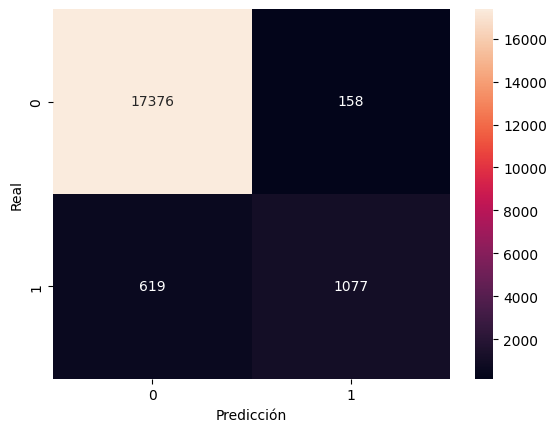

In [ ]:
run = mlflow.start_run(experiment_id=exp_id, run_name="Regresion_logistica")
model = LogisticRegression(**params).fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
fig.savefig("confusion_matrix.png")

mlflow.log_params(params)
mlflow.sklearn.log_model(model, "model")
mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
mlflow.log_metrics({
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred)
    })
mlflow.end_run()

### C-Support Vector Classification.
--------------------------------------------
Otro algorimo utilizado es el super vector machine para clasificación, que se caraxteriza por buscar una region optima que separe diferentes clases de datos en un margen considerable. Es decir que buscar un hiperplano que maxime la distancia entre las clases que se necesite diferenciar, ademas que puede trabajar en casos de linealidad y no linealidad. Para nuestro caso vamos a probar, variando hiperparametros como el tipo de kernel, la tasa de optimizacion "C" y el valor de gamma.

In [ ]:
param_grid_svc = {
    'kernel': ['linear','rbf', 'sigmoid'],
    'C': [0.001 ,0.01, 0.1],
    'gamma': ['scale', 'auto', float]
}

Se genera la herramiento gridSearchCv, configruada para 3 folds

In [ ]:
grid_svc = GridSearchCV(SVC(random_state=3),
                   param_grid=param_grid_svc,
                   verbose=1,
                   return_train_score=True,
                   cv = 3
                   )
grid_svc.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
27 fits failed out of a total of 81.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

GridSearchCV(cv=3, estimator=SVC(random_state=3),
             param_grid={'C': [0.001, 0.01, 0.1],
                         'gamma': ['scale', 'auto', <class 'float'>],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             return_train_score=True, verbose=1)

Se crea un dataframe con los resultados de los 5 primeros modelos, donde encuentra los hiperparateros, y las metricas especificas y generales de cada iteración.

In [ ]:
pd.DataFrame(grid_svc.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
21,10.721888,0.412619,3.653001,0.232676,0.10,auto,linear,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}",0.959437,0.958111,0.957797,0.958448,0.000711,1,0.958168,0.958558,0.958462,0.958396,0.000166
18,9.957602,0.852294,4.550364,0.860740,0.10,scale,linear,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.959437,0.958111,0.957797,0.958448,0.000711,1,0.958168,0.958558,0.958462,0.958396,0.000166
19,17.404999,0.582944,9.721616,0.766284,0.10,scale,rbf,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.957565,0.956980,0.956042,0.956862,0.000627,3,0.956803,0.956823,0.957506,0.957044,0.000327
22,19.609837,0.977092,11.331634,0.667110,0.10,auto,rbf,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.953391,0.953352,0.952726,0.953157,0.000305,4,0.953156,0.953215,0.953703,0.953358,0.000245
12,12.674488,0.502227,4.778007,0.342849,0.01,auto,linear,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'linear'}",0.953040,0.952728,0.951985,0.952585,0.000442,5,0.952142,0.952532,0.952806,0.952494,0.000272


Por separado, se extraen del mejor modelo, sus hiperametros y sus metricas de entrenamiento y prueba.

In [ ]:
params=grid_svc.best_params_
print(grid_svc.best_estimator_)
print(grid_svc.best_score_)
print(grid_svc.score(X_test, y_test))

SVC(C=0.1, kernel='linear', random_state=3)
0.9584481687665932
0.9593863754550181


In [ ]:
print(f"Best parameters: {grid_svc.best_params_}")

Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


Se almacena el mejor modelo de SVC para evitar volver a aplicar la CV

In [ ]:
svc_bm = grid_svc.best_estimator_
joblib.dump(svc_bm, 'svc_best_model.joblib')

['svc_best_model.joblib']

Se carga el mejor modelo y se obtienen predicciones

In [ ]:
model_svc = joblib.load("svc_best_model.joblib")
y_pred_svc = model_svc.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
params = model_svc.get_params()

Se obtiene el clasification report de SVC

In [ ]:
print(classification_report(y_test,y_pred_svc, target_names=['No_Diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No_Diabetes       0.96      1.00      0.98     17534
    Diabetes       0.94      0.58      0.72      1696

    accuracy                           0.96     19230
   macro avg       0.95      0.79      0.85     19230
weighted avg       0.96      0.96      0.95     19230



La matriz de confusión muestra que solo 78 casos de no diabetes fueron mal clasificados por lo que el algrotimo funciona bien clasificando este tipo. Pero, el porcentaje de casos de diabetes que fueron bien clasificados estan cercanos a los que no fueron bien clasificados, lo que indica que el algoritmo tiene problemas al decidir a que tipo de clase pertenece un registro u otro de manera mas frecuente.

In [ ]:
svc_mat = confusion_matrix(y_test, y_pred_svc)
list_confusion_matrix(svc_mat, ['No_Diabetes', 'Diabetes'])

Valor predicho         
                          No_Diabetes Diabetes
Valor real No_Diabetes          17466       68
           Diabetes               713      983

En **MLflow** se carga en el experimento **diabetes_model** el modelo de **Clasificación de Maquina de Soporte Vectorial** con los mejores hiperparametros identificados.

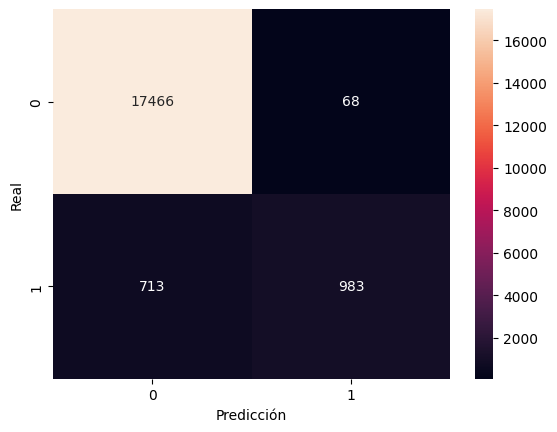

In [ ]:
run = mlflow.start_run(experiment_id=exp_id, run_name="Maquina_Soporte_vec")
model = SVC(**params).fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
fig.savefig("confusion_matrix.png")

mlflow.log_params(params)
mlflow.sklearn.log_model(model, "model")
mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
mlflow.log_metrics({
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred)
    })
mlflow.end_run()

### **K-Nearest Neighbors Classifier**
-----------
Algoritmo de k vecinos más cercanos, también conocido como KNN o k-NN, es un clasificador de aprendizaje supervisado no paramétrico, que utiliza la proximidad para hacer clasificaciones o predicciones sobre la agrupación de un punto de datos individual.

In [ ]:
param_grid = {
    'n_neighbors': list(range(2, 7)),
    'p': (1,2),
    'weights': ('uniform',),
}

In [ ]:
gsearch = GridSearchCV(
                      estimator=KNeighborsClassifier(),
                      param_grid=param_grid,
                      verbose=3,
                      cv=3,
                      n_jobs = -1,
                      scoring='accuracy',
                      return_train_score=True
          ).fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
#Cálculo de los resultados del Grid
pd.DataFrame(gsearch.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,0.233518,0.002374,29.267582,4.231537,2,2,uniform,"{'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}",0.960178,0.958033,0.959435,0.959215,0.000889,1,0.970552,0.971742,0.970923,0.971072,0.000497
5,0.246314,0.007533,29.166253,2.838785,4,2,uniform,"{'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}",0.960490,0.957565,0.958967,0.959007,0.001195,2,0.965657,0.966827,0.966165,0.966216,0.000479
9,0.240667,0.014519,30.168984,1.439375,6,2,uniform,"{'n_neighbors': 6, 'p': 2, 'weights': 'uniform'}",0.960295,0.958345,0.958382,0.959007,0.000911,3,0.963648,0.964136,0.964722,0.964169,0.000439
7,0.235444,0.006876,29.588744,1.319136,5,2,uniform,"{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.959866,0.956941,0.959162,0.958656,0.001247,4,0.967042,0.967861,0.967861,0.967588,0.000386
8,0.234478,0.005423,35.137801,2.185022,6,1,uniform,"{'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}",0.959164,0.957526,0.958733,0.958474,0.000693,5,0.963765,0.963785,0.963922,0.963824,0.000070


In [ ]:
params=gsearch.best_params_
print(gsearch.best_estimator_)
print(gsearch.best_score_)

KNeighborsClassifier(n_neighbors=2)
0.959215250662576


In [ ]:
model = gsearch.best_estimator_
joblib.dump(model, "KNN_model.joblib")

['KNN_model.joblib']

In [ ]:
model = joblib.load("KNN_model.joblib")

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# Generación de la matriz de confusión.
KNN_mat = confusion_matrix(y_test, y_pred)
list_confusion_matrix(KNN_mat, ['No_Diabetes', 'Diabetes'])

Valor predicho         
                          No_Diabetes Diabetes
Valor real No_Diabetes          17466       68
           Diabetes               713      983

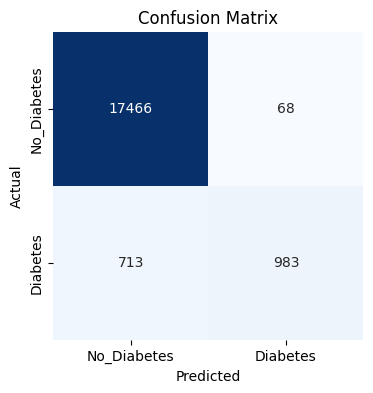

In [ ]:
plt.figure(figsize=(4, 4))
sns.heatmap(KNN_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Estimación de los estadísticos de desempeño del modelo.
print(f'Orden de las etiquetas: {names}')
print(f'Precisión por clase: \t{precision_score(y_test, y_pred, average=None)}')
print(f'Recall por clase: \t{recall_score(y_test, y_pred, average=None)}')
print(f'Recall por clase: \t{f1_score(y_test, y_pred, average=None)}')

Orden de las etiquetas: ['No_Diabetes', 'Diabetes']
Precisión por clase: 	[0.96077892 0.93529971]
Recall por clase: 	[0.99612182 0.57959906]
Recall por clase: 	[0.97813121 0.71568984]


En **MLflow** se carga en el experimento **diabetes_model** el modelo de **Clasificación de Vecinos cercanos** con los mejores hiperparametros identificados.

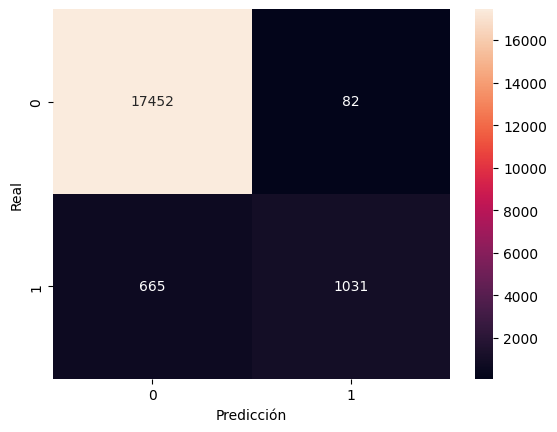

In [ ]:
run = mlflow.start_run(experiment_id=exp_id, run_name="Vecinos_cercanos")
model = KNeighborsClassifier(**params).fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
fig.savefig("confusion_matrix.png")

mlflow.log_params(params)
mlflow.sklearn.log_model(model, "model")
mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
mlflow.log_metrics({
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred)
    })
mlflow.end_run()

### **Stochastic Gradient Descent Classifier**
--------------
El descenso del gradiente es un algoritmo de optimización que se utiliza comúnmente para entrenar modelos de aprendizaje automático y redes neuronales. Entrena modelos de aprendizaje automático minimizando los errores entre los resultados previstos y los reales, presenta un buen desempeño en ejercicio de clasificación binaria.

In [ ]:
penalty = ['l1']
alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
max_iter = [int(x) for x in np.linspace(1000, 10000, num = 19)]
loss = ['hinge', 'log', 'modified_huber', 'squared_hinge',
'perceptron']
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
eta0 = [1, 10, 100]

random_grid = {
    'penalty' : penalty,
    'alpha' : alpha,
    'max_iter' : max_iter,
    'loss': loss,
    'learning_rate' : learning_rate,
    'class_weight' : class_weight,
    'eta0' : eta0
}

In [ ]:
SGDsearch = RandomizedSearchCV(
                            estimator=SGDClassifier(),
                            param_distributions=random_grid,
                            verbose=3,
                            cv=3,
                            n_iter=20,
                            n_jobs = -1,
                            scoring='accuracy',
                            return_train_score=True
        ).fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
12 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_p

In [ ]:
#Cálculo de los resultados del Grid
pd.DataFrame(SGDsearch.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_max_iter,param_loss,param_learning_rate,param_eta0,param_class_weight,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
17,0.295611,0.034061,0.016694,0.003650,l1,6000,hinge,optimal,1,"{1: 0.7, 0: 0.3}",...,0.957604,0.957485,0.957278,0.000380,1,0.956569,0.957564,0.958208,0.957447,0.000674
6,0.273035,0.033341,0.006179,0.000035,l1,8500,modified_huber,optimal,10,"{1: 0.6, 0: 0.4}",...,0.955849,0.956510,0.956862,0.001003,2,0.958207,0.954346,0.958072,0.956875,0.001789
18,0.525594,0.034939,0.015819,0.001586,l1,1000,hinge,invscaling,1,"{1: 0.7, 0: 0.3}",...,0.957409,0.955769,0.956459,0.000694,3,0.955731,0.956628,0.956863,0.956407,0.000488
16,3.145394,0.048218,0.011799,0.003408,l1,2500,modified_huber,adaptive,100,"{1: 0.7, 0: 0.3}",...,0.955029,0.953389,0.954119,0.000682,4,0.953995,0.953683,0.955244,0.954307,0.000674
12,0.160384,0.036397,0.008001,0.002074,l1,4000,squared_hinge,constant,100,"{1: 0.5, 0: 0.5}",...,0.952299,0.938958,0.946175,0.005501,5,0.948105,0.951752,0.939467,0.946442,0.005151


In [ ]:
params=SGDsearch.best_params_
print(SGDsearch.best_estimator_)
print(SGDsearch.best_score_)

SGDClassifier(alpha=0.001, class_weight={0: 0.3, 1: 0.7}, eta0=1, max_iter=6000,
              penalty='l1')
0.9572780722724915


In [ ]:
model = SGDsearch.best_estimator_
joblib.dump(model, "SGD_model.joblib")

['SGD_model.joblib']

In [ ]:
model = joblib.load("SGD_model.joblib")

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# Generación de la matriz de confusión.
SGD_mat = confusion_matrix(y_test, y_pred)
list_confusion_matrix(KNN_mat, ['No_Diabetes', 'Diabetes'])

Valor predicho         
                          No_Diabetes Diabetes
Valor real No_Diabetes          17466       68
           Diabetes               713      983

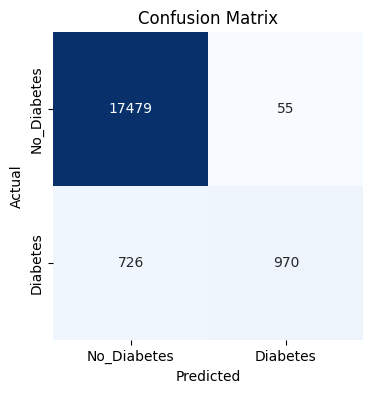

In [ ]:
plt.figure(figsize=(4, 4))
sns.heatmap(SGD_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Estimación de los estadísticos de desempeño del modelo.
print(f'Orden de las etiquetas: {names}')
print(f'Precisión por clase: \t{precision_score(y_test, y_pred, average=None)}')
print(f'Recall por clase: \t{recall_score(y_test, y_pred, average=None)}')
print(f'Recall por clase: \t{f1_score(y_test, y_pred, average=None)}')

Orden de las etiquetas: ['No_Diabetes', 'Diabetes']
Precisión por clase: 	[0.96568627 0.84507042]
Recall por clase: 	[0.98870765 0.63679245]
Recall por clase: 	[0.97706138 0.72629455]


En **MLflow** se carga en el experimento **diabetes_model** el modelo de **Clasificación de Gradiente Estocástico** con los mejores hiperparametros identificados.

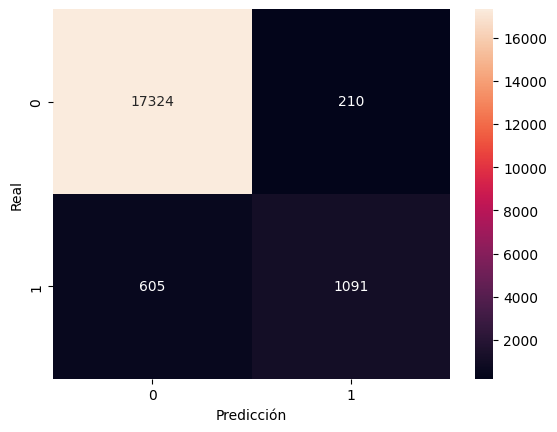

In [ ]:
run = mlflow.start_run(experiment_id=exp_id, run_name="Gradiente_Estocastico")
model = SGDClassifier(**params).fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
fig.savefig("confusion_matrix.png")

mlflow.log_params(params)
mlflow.sklearn.log_model(model, "model")
mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
mlflow.log_metrics({
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred)
    })
mlflow.end_run()

### **Arbol de Decisión**
--------------------
Este es un algoritmo de aprendizaje supervisado utilizado para problemas de clasificación. Funciona construyendo un árbol de decisiones en el que cada nodo representa una característica, cada borde representa una regla de decisión y cada hoja representa la etiqueta de clase.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
Tree_classifier= DecisionTreeClassifier()
Tree_classifier=Tree_classifier.fit(X_train,y_train)

In [ ]:
print(f'Exactitud en entrenamiento: {Tree_classifier.score(X_train, y_train):.4f}')
print(f'Error en entrenamiento: {1 - Tree_classifier.score(X_train, y_train):.4f}')

Exactitud en entrenamiento: 0.9991
Error en entrenamiento: 0.0009


In [ ]:
print(f'Exactitud en prueba: {Tree_classifier.score(X_test, y_test):.4f}')
print(f'Error prueba: {1 - Tree_classifier.score(X_test, y_test):.4f}')

Exactitud en prueba: 0.9473
Error prueba: 0.0527


In [ ]:
param_grid= {"max_depth": range(1,5,1),
             "criterion": ["gini","entropy"],
             "min_samples_split": range(1,20,1),
             "min_samples_leaf": range(1,20,1)
             }

In [ ]:
grid_clf = GridSearchCV(DecisionTreeClassifier(),
                        param_grid=param_grid,
                        return_train_score=True
)

In [ ]:
grid_clf.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
760 fits failed out of a total of 14440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
760 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 5),
                         'min_samples_leaf': range(1, 20),
                         'min_samples_split': range(1, 20)},
             return_train_score=True)

In [ ]:
params=grid_clf.best_params_
print(grid_clf.best_params_)

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
print(grid_clf.best_score_)

0.9705522738883943


In [ ]:
grid_clf.score(X_test,y_test)

0.971606864274571

In [ ]:
Arbol = grid_clf.best_estimator_
joblib.dump(Arbol, "AD_model.joblib")

['AD_model.joblib']

In [ ]:
model = joblib.load("AD_model.joblib")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.metrics.cluster import contingency_matrix

In [ ]:
y_pred_DTC = model.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred_DTC, target_names=['No_Diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No_Diabetes       0.97      1.00      0.98     17534
    Diabetes       1.00      0.68      0.81      1696

    accuracy                           0.97     19230
   macro avg       0.98      0.84      0.90     19230
weighted avg       0.97      0.97      0.97     19230



In [ ]:
lg_DTC = confusion_matrix(y_test, y_pred_DTC)
list_confusion_matrix(lg_DTC, ['No_Diabetes', 'Diabetes'])

Valor predicho         
                          No_Diabetes Diabetes
Valor real No_Diabetes          17534        0
           Diabetes               546     1150

En **MLflow** se carga en el experimento **diabetes_model** el modelo de **Clasificación de Arbol de Decisión** con los mejores hiperparametros identificados.

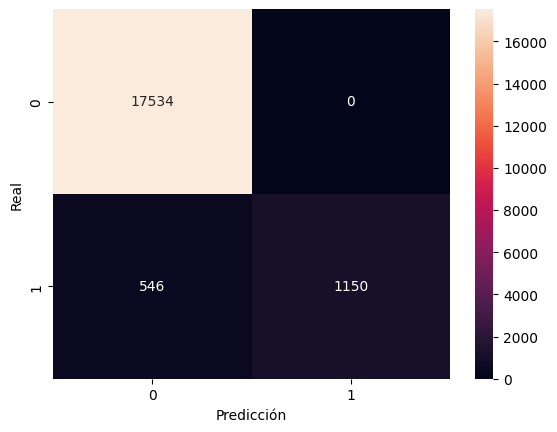

In [ ]:
run = mlflow.start_run(experiment_id=exp_id, run_name="Arbol_decision")
model = DecisionTreeClassifier(**params).fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
fig.savefig("confusion_matrix.png")

mlflow.log_params(params)
mlflow.sklearn.log_model(model, "model")
mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
mlflow.log_metrics({
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred)
    })
mlflow.end_run()

### **Randon Forest**
-----------
Bosque aleatorio es un método de aprendizaje que opera mediante la construcción de múltiples árboles de decisión. La decisión final se toma en base a la mayoría de los árboles, es un algoritmo muy potente que se ajusta muy bien a problemas de clasificación.

In [ ]:
RF_classifier= RandomForestClassifier()
RF_classifier=RF_classifier.fit(X_train,y_train)

In [ ]:
param_grid= {'criterion': ['gini', 'entropy'],
            'max_depth': [2, 20, 50,100],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1,5,10,20],
            'min_samples_split': [1,5,10,20],
            'n_estimators': [2,10,50,100]
            }

In [ ]:
RFsearch = GridSearchCV(
                      estimator=RandomForestClassifier(),
                      param_grid=param_grid,
                      verbose=3,
                      cv=3,
                      n_jobs = -1,
                      scoring='accuracy',
                      return_train_score=True
          ).fit(X_train, y_train)

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1920 fits failed out of a total of 3072.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1049 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sk

In [ ]:
#Cálculo de los resultados del Grid
pd.DataFrame(RFsearch.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
853,0.579140,0.030783,0.044225,0.001870,entropy,50,sqrt,5,5,10,...,0.970475,0.970396,0.970812,0.000534,1,0.972736,0.973009,0.972756,0.972834,0.000124
346,4.615779,0.817947,0.310961,0.079695,gini,50,sqrt,5,10,50,...,0.970475,0.970239,0.970786,0.000615,2,0.971976,0.972249,0.972366,0.972197,0.000164
223,5.638307,0.315330,0.493475,0.161356,gini,20,sqrt,5,20,100,...,0.970436,0.970161,0.970760,0.000663,3,0.970942,0.971703,0.971801,0.971482,0.000384
847,6.348486,0.528358,0.481807,0.132533,entropy,50,sqrt,1,20,100,...,0.970553,0.970122,0.970760,0.000623,4,0.971800,0.972385,0.972386,0.972190,0.000276
335,6.894857,0.879745,0.432540,0.042083,gini,50,sqrt,1,20,100,...,0.970280,0.970200,0.970721,0.000681,5,0.971878,0.972229,0.972405,0.972171,0.000219


In [ ]:
print(RFsearch.best_estimator_)
print(RFsearch.best_score_)

RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=5,
                       min_samples_split=5, n_estimators=10)
0.9708123093140224


In [ ]:
model_RF = RFsearch.best_estimator_
joblib.dump(model_RF, "RF_model.joblib")

['RF_model.joblib']

In [ ]:
model = joblib.load("RF_model.joblib")

In [ ]:
params = model.get_params()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred, target_names=['No_Diabetes', 'Diabetes'], digits=4))

              precision    recall  f1-score   support

 No_Diabetes     0.9702    0.9990    0.9844     17534
    Diabetes     0.9847    0.6828    0.8064      1696

    accuracy                         0.9711     19230
   macro avg     0.9774    0.8409    0.8954     19230
weighted avg     0.9715    0.9711    0.9687     19230



In [ ]:
names=['No_Diabetes', 'Diabetes']
RF_mat = confusion_matrix(y_test, y_pred)
list_confusion_matrix(RF_mat, ['No_Diabetes', 'Diabetes'])

Valor predicho         
                          No_Diabetes Diabetes
Valor real No_Diabetes          17516       18
           Diabetes               538     1158

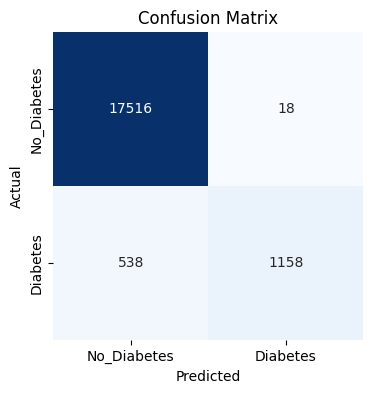

In [ ]:
plt.figure(figsize=(4, 4))
sns.heatmap(RF_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=names, yticklabels=names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

En **MLflow** se carga en el experimento **diabetes_model** el modelo de **Clasificación de Randon Forest** con los mejores hiperparametros identificados.

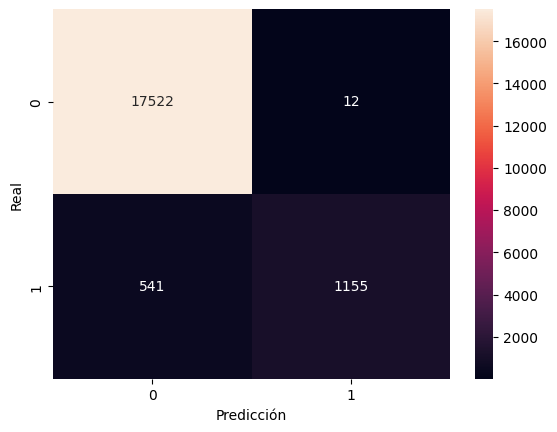

In [ ]:
run = mlflow.start_run(experiment_id=exp_id, run_name="Bosques_aleatorios")
model = RandomForestClassifier(**params).fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
fig.savefig("confusion_matrix.png")

mlflow.log_params(params)
mlflow.sklearn.log_model(model, "model")
mlflow.log_artifact("confusion_matrix.png", "confusion_matrix")
mlflow.log_metrics({
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred)
    })
mlflow.end_run()

## **Experimento Diabetes en MLflow**
---------------------
De esta manera, desde MLflow, se puede realizar el seguimi9ento completo al proyecto **Diabetes_model**, así como los diferentes modelos y los versionamientos de los mismos como se observa a continuación:

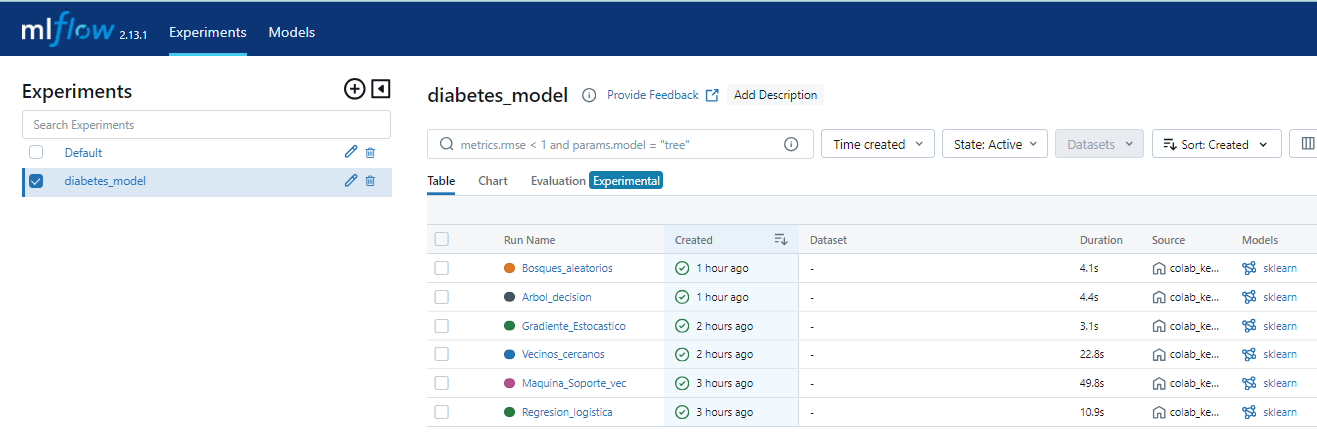

De igual manera, se presentan los resultados de las diferentes métricas de evaluación empleadas para la identificación y evaluación comparativa de los modelos empelados.

-------------------

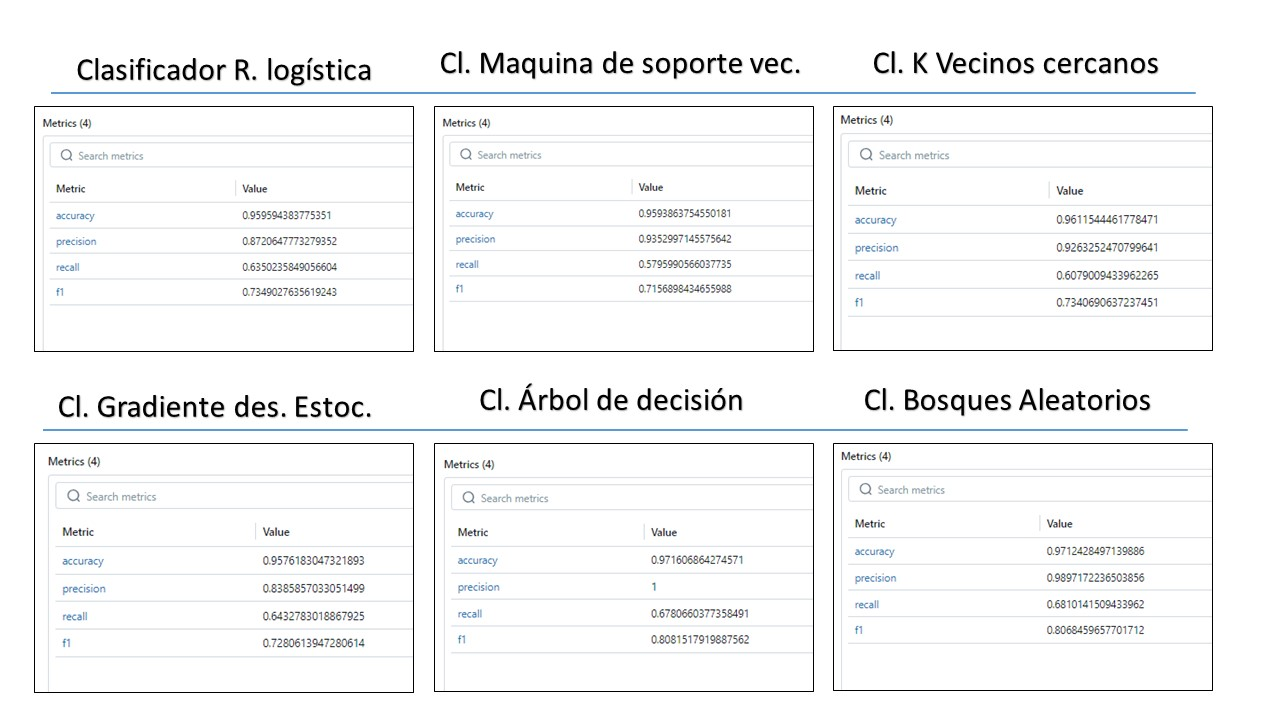